## Importando bibliotecas

In [83]:
# Ocultando mensagens do sistema
import warnings
warnings.filterwarnings('ignore')

# Bibliotecas iniciais
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregando bibliotecas para pré-processamento
import re
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import unicodedata

## Inspeção Inicial dos dados

Os dados deste dataset foram preparados neste mesmo repositório do GitHub, em um notebook nomeado `Dataset.jpynb` , onde foram concatenados cerca de cinco datasets com avaliações de restaurantes em diferentes países.

In [24]:
data = pd.read_csv('restaurantes.csv')
df = pd.DataFrame(data)

In [26]:
print(f"\n↳ Quantidade de linhas: {df.shape[0]}")
print(f"↳ Quantidade de colunas: {df.shape[1]}\n")
df.head(3)


↳ Quantidade de linhas: 2299006
↳ Quantidade de colunas: 13



,Unnamed: 0,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
0,0,1,Chalito_Rambla,1,Negative,review_774086112,Terrible food Terrible service,"Ok, this place is terrible! Came here bc we’ve...","Ok, this place is terrible! Came here bc we’ve...","October 12, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
1,1,2,Chalito_Rambla,5,Positive,review_739142140,The best milanesa in central Barcelona,This place was a great surprise. The food is d...,This place was a great surprise. The food is d...,"January 14, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
2,2,3,Chalito_Rambla,5,Positive,review_749758638,Family bonding,The food is excellent.....the ambiance is very...,The food is excellent.....the ambiance is very...,"March 7, 2020",Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,UID_2


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2299006 entries, 0 to 2299005
Data columns (total 13 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Unnamed: 0       object
 1   parse_count      object
 2   restaurant_name  object
 3   rating_review    object
 4   sample           object
 5   review_id        object
 6   title_review     object
 7   review_preview   object
 8   review_full      object
 9   date             object
 10  city             object
 11  url_restaurant   object
 12  author_id        object
dtypes: object(13)
memory usage: 228.0+ MB


## Limpeza, Manipulação e Preparação

Para este projeto, irei precisar apenas de algumas colunas desse dataset, sendo elas:

- `rating_review` é utilizada para analisar a pontuação do usuário, de `1` à `5` (do pior para o melhor).
- `sample` é a coluna que contém uma avaliação de sentimento do comentário, sendo ela `Negative` ou `Positive` .
- `review_full` contém o comentário completo dos usuário em relação ao restaurante, todos eles estão em inglês.

**Objetivos Iniciais**
- Criar um novo DataFrame com as 3 tabelas citadas acima, renomeando-as para se encaixar melhor ao propósito deste projeto.
- Identificar se existe um desbalanceamento na quantidade de avaliações positivas e negativas.
- Estudar o impacto das pontuações de `1` à `5` e estudar possibilidade de classificar um novo sentimento como `Neutral` .


In [145]:
# Preparando novo dataframe com as colunas 'rating_review', 'sample' e 'review_full'
df_pln = df[['rating_review', 'sample', 'review_full']]

# Renomenado colunas
df_pln = df_pln.rename(columns={'rating_review': 'ratings', 'sample': 'sentiments', 'review_full': 'reviews'})

df_pln.head()

,ratings,sentiments,reviews
0,1,Negative,"Ok, this place is terrible! Came here bc we’ve..."
1,5,Positive,This place was a great surprise. The food is d...
2,5,Positive,The food is excellent.....the ambiance is very...
3,5,Positive,"The food is execellent ,affortable price for p..."
4,5,Positive,"Mr Suarez,The food at your restaurant was abso..."


In [147]:
# Porcentagem de valores faltantes
print(f"Quantidade de valores ausentes:\n{df_pln.isna().sum()}")

Quantidade de valores ausentes:
ratings           9
sentiments        9
reviews       51199
dtype: int64


Existem cerca de 51k de comentários ausentes em `reviews` e apenas alguns valores ausentes em `ratings` e `sentiments` . Abaixo irei dar uma leve olhada nesses dados e remover do DataFrame.

In [150]:
# Observando os valores ausentes
df_pln[df_pln['reviews'].isnull()].head(10)

,ratings,sentiments,reviews
187262,4,Positive,NaN
187263,Barcelona_Catalonia,https://www.tripadvisor.com/Restaurant_Review-...,NaN
612489,4.0,Positive,NaN
612490,London_England,https://www.tripadvisor.com/Restaurant_Review-...,NaN
828375,5.0,Positive,NaN
828376,NaN,NaN,NaN
828377,NaN,NaN,NaN
828378,NaN,NaN,NaN
828379,London_England,https://www.tripadvisor.com/Restaurant_Review-...,NaN
1009105,5.0,Positive,NaN


In [152]:
# Dropando valores ausentes
df_pln = df_pln.dropna()
print(f"Quantidade de valores ausentes:\n{df_pln.isna().sum()}")

Quantidade de valores ausentes:
ratings       0
sentiments    0
reviews       0
dtype: int64


Com os dados limpos, vamos iniciar uma contagem das categorias `ratings` e `sentiments` para termos uma noção da distribuição dos dados.

In [155]:
# Contagem de valores categóricos
df_categ = df_pln.groupby(['ratings', 'sentiments']).size().reset_index(name='Count').sort_values(by='Count', ascending=False)
df_categ

,ratings,sentiments,Count
4,5,Positive,967675
3,4,Positive,463400
2,3,Negative,160845
14,5.0,Positive,152569
13,5,Positive,136328
0,1,Negative,75039
1,2,Negative,73495
11,4,Positive,70711
12,4.0,Positive,67050
10,3.0,Negative,22905


A coluna `ratings` está despadronizada trazendo muitos resultados reduldantes e desorganizados.

Para resolver esse problema, irei padronizar os números dessa coluna para `float` e agregar com seus respectivos sentimentos.

In [158]:
# Transformando a coluna 'rating' em float
df_categ['ratings'] = df_categ['ratings'].astype(float)

# Agregando a coluna em rating
df_rating = df_categ.groupby(['ratings', 'sentiments']).agg({'Count': 'sum'}).reset_index()
df_rating.sort_values(by='ratings', ascending=False)

,ratings,sentiments,Count
4,5.0,Positive,1256572
3,4.0,Positive,601161
2,3.0,Negative,205974
1,2.0,Negative,92307
0,1.0,Negative,91793


## Análise Exploratória

Vamos começar a análise observando a quantidade de comentários positivos e negativos, assim como a possibilidade de aderirmos um novo sentimento nomeado como `Neutral`

Abaixo, irei preparar algumas variáveis e organizar duas plotagens para estudar nossos dados.

In [162]:
# Preparando variáveis para plotagem
positive_count = df_rating.loc[df_rating['sentiments'] == 'Positive', 'Count'].values[0]
negative_count = df_rating.loc[df_rating['sentiments'] == 'Negative', 'Count'].values[0]

# Cores para os plots
cores = ['#d62828', '#ff9e00', '#eeef20', '#aacc00', '#55a630']

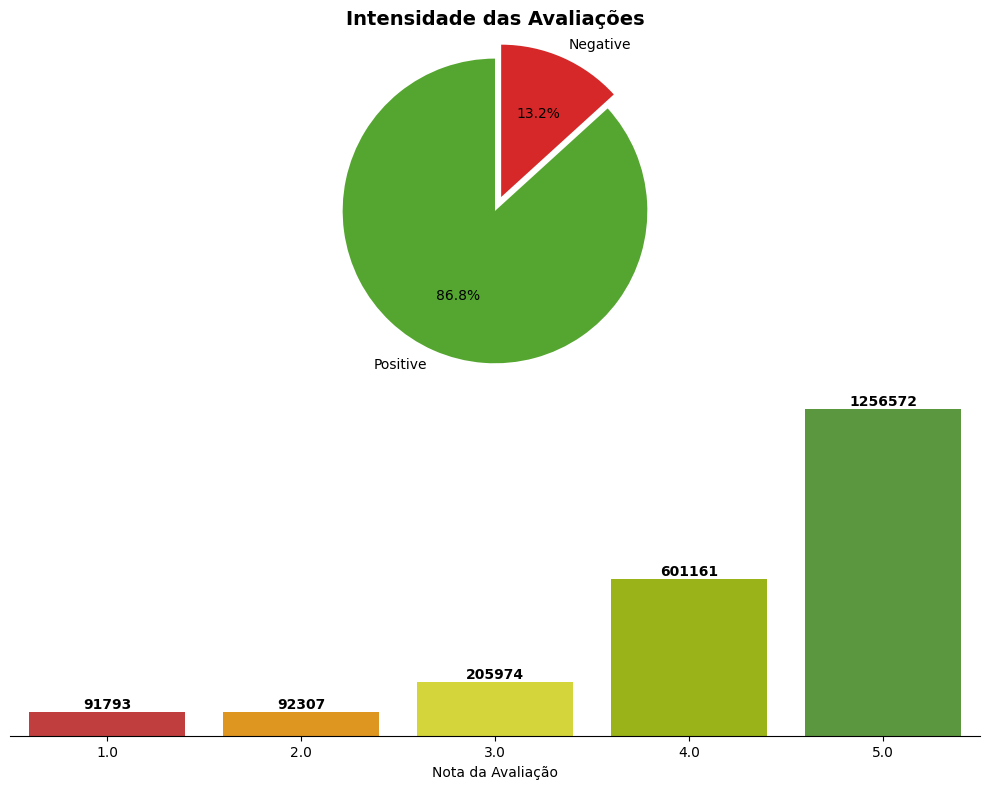

In [168]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

#------------------
# Primeiro subplot: Gráfico de pizza (intensidade)
#------------------
axes[0].pie([positive_count, negative_count],
            labels=['Positive', 'Negative'],
            colors= [cores[4], cores[0]],
            autopct='%1.1f%%',
            startangle=90,
            explode=(0.1, 0))

axes[0].set_title('Intensidade das Avaliações', fontsize=14, fontweight='bold')
axes[0].axis('equal')

#------------------
# Segundo subplot: Gráfico de barras (contagem)
#------------------
ax = sns.barplot(x=df_rating['ratings'],
                 y=df_rating['Count'],
                 palette=cores, ax=axes[1])

for i in range(len(df_rating['ratings'])):
    axes[1].annotate(f'{df_rating["Count"][i]:.0f}'.replace('.', ','),
                (i, df_rating['Count'][i]),
                ha="center",
                xytext=(0, 3),
                textcoords="offset points",
                fontweight='bold')

# Ocultando eixos e algumas bordas
axes[1].yaxis.set_visible(False)
axes[1].spines["top"].set_visible(False)
axes[1].spines["left"].set_visible(False)
axes[1].spines["right"].set_visible(False)

axes[1].set_title('')
axes[1].set_xlabel('Nota da Avaliação')
axes[1].set_ylabel('Contagem')

plt.tight_layout()
plt.show()

- É evidente que existe um enorme desbalanceamento de avaliações `Positive` em relação às `Negative`. Isso é um pequeno problema para avaliar nosso modelo e será necessário aplicar algumas técnicas para balancear esses dados.

- Em relação às notas das avaliações, existe uma quantidade bem maior para notas contendo pontuação em `4` e `5`. Sabemos que as outras pontuação são do sentimento `Negative` contendo apenas `13,2%` de todo o dataset.

Vamos avaliar as pontuações com nota `3` e observar a necessidade de criar ou não um novo sentimento como `Neutral` .


In [107]:
 # Aqui irei dropar a coluna "Count" por nao ser mais necessária
df_rating = df_rating.drop('Count', axis=1)

# Unindo o Dataframe limpo com o que possui as reviews
df_pln = pd.merge(df_rating, df_pln[['ratings', 'sentiments', 'reviews']], on=['ratings', 'sentiments'], how='left')
df_pln['ratings'] = df_pln['ratings'].astype(int)

In [108]:
print(f"\n↳ Quantidade de linhas com os dados limpos: {df_pln.shape[0]}\n")
df_pln.head(3)


↳ Quantidade de linhas com os dados limpos: 1740454



,ratings,sentiments,reviews
0,1,Negative,"Ok, this place is terrible! Came here bc we’ve..."
1,1,Negative,I always enjoyed above the average-to-outstand...
2,1,Negative,second visit there and i am very disapointed t...


In [109]:
# Estudando alguns comentários com nota 3
nota_3 = df_pln[df_pln['ratings'] == 3]
print("➥ Analisando os sentimentos de alguns comentários com nota 3:\n")
for i, review in enumerate(nota_3.iloc[0:5, :]['reviews'], start=1):
    print(f"{i}ª Review: {review}\n")
print("...")

➥ Analisando os sentimentos de alguns comentários com nota 3:

1ª Review: We went there for dinner further a friend’s recommendation. The menu is pretty large, the service was a bit disappointing, when we asked few recommendations to the waiter about the wine for instance, you need to push to have some advises. The food was acceptable, we had a carpaccio of octopus as a starter which was a bit disappointing too (couldn’t feel properly the taste of the octopus). Regarding the pizza they were very yummy.

2ª Review: Um, how this joint has this many 5 star reviews will FOREVER vex me. Dramatic presentation, for sure, but the execution was spotty at best for such an extremely focused menu. Will not return.

3ª Review: I am so confused by the positive reviews of the food. This is just not good Spanish food. Our drinks were great, but the suckling pig was dry and tough. We ate none of it because it was so bad. We had the spring rolls, which were good and a few other items. The server not ver

- Os comentários com nota 3 tendem a ser negativos, descrevendo experiências que não agregam valor positivo para o cliente. Por isso, não podemos inferir um sentimento claro a partir da ausência de especificidades em alguns comentários.

Vamos analisar os comentários com nota 4 para verificar se eles influenciam uma classificação Positiva.

In [114]:
nota_4 = df_pln[df_pln['ratings'] == 4]
print("➥ Analisando os sentimentos de alguns comentários com nota 4:\n")
for i, review in enumerate(nota_4.iloc[0:5, :]['reviews'], start=1):
    print(f"{i}ª Review: {review}\n")
print("...")

➥ Analisando os sentimentos de alguns comentários com nota 4:

1ª Review: I visited this placed yesterday to catch a quick bite before heading for the airport. We were greeted by a young man at the entrance who told use we could choose where we sat. We sat down and spent the next 5min or so being ignored. My partner was getting annoyed even so that the 3 young lads at the next table picked up on this and gave us their menus as they had already orderd. Again we spent some time being ignored before we stopped one of the staff walking by to take our order. The good came out quite quickly and to be fair it was very good. After we had finished we again had to ask the staff to clear the table and give us a dessert menu. The lad that we hsd asked wss just finishing and he told us to ask one of his other colleagues who he pointed to. My partner went over and asked for the menu and was told that there was none and that he had had to go inside the restaurant to the counter and pick out what he w

Com base nos comentários com nota 4, podemos observar uma tendência geral para o positivo, apesar da primeira avaliação apresentar uma experiência mista. A maioria dos clientes elogia a comida, o ambiente e o serviço (com a exceção do primeiro relato). Portanto, esses comentários parecem influenciar uma classificação geral mais positiva em relação ao estabelecimento.

## Pré-Processamento

Antes de começarmos a planejar uma função, irei fazer uma checagem das principais dependências que serão utilizadas para essa etapa do projeto

In [118]:
# Certifique-se de ter os recursos do NLTK baixados
try:
    stopwords.words('english')
    WordNetLemmatizer()
except LookupError:
    nltk.download('stopwords')
    nltk.download('wordnet')
    nltk.download('punkt')  # necessário para word_tokenize
    nltk.download('omw-1.4') #necessario para o wordnet

A função a seguir será nossa base principal para fazer o pré-processamento de todos os `reviews` presentes no DataFrame, isso inclui:
- Normalização Unicode
- Remoção de caracteres especiais (mantendo as letras em caso de acentos)
- Remoção de números
- Remoção de espaços extras
- Tokenização das palavras
- Lematização das palavras


**Tokenização:** Basicamente, isso irá criar um vetor para cada palavra dos comentários, facilitando para uma etapa posterior de vetorização (transformar palavras em números) e permitindo que apliquemos um modelo para ensinar nossa máquina de avaliação de sentimentos.

**Lematização:** Isso transforma todas as variações de uma determinada palavra para sua base de origem, como `running > run`, `is > be` ou o plural `mice` para o singular `mouse` . 

In [120]:
def text_preprocessing(text):
    """
    Preprocessa um texto removendo HTML, caracteres especiais, URLs,
    convertendo para minúsculas, removendo números, stop words e lematizando.

    Args:
        text (str): O texto a ser pre-processado.

    Returns:
        str: O texto pre-processado.  Retorna uma string vazia em caso de erro.
    """
    try:
        # Normalização Unicode (NFD = Decomposição Canônica)
        text = unicodedata.normalize('NFD', text)
        text = ''.join([c for c in text if not unicodedata.combining(c)])

        # Remover números
        text = re.sub(r'\d+', '', text)

        # Remover caracteres especiais e manter apenas letras, números e espaços
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)


        # Remover espaços extras
        text = re.sub(r'\s+', ' ', text)


        tokens = word_tokenize(text)


        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        lemmatizer = WordNetLemmatizer()
        tokens_sl = [lemmatizer.lemmatize(token) for token in tokens]

        return " ".join(tokens_sl)
    except Exception as e:
        print(f"Erro no pre-processamento: {e}") #log de erros
        return ""  # Retorna string vazia em caso de erro


Por se tratar de um dataframe com muitos dados, irei aplicar uma vetorização parcial para adiantar algumas etapas de pré-processamentos que não foram inclusas na função, como:
- Remoção de símbolos HTML
- Remoção de tags e URLs
- Conversão para letras minúsculas

Isso irá aliviar um pouco a carga para a etapa principal de pré-processamento.

In [122]:
# Exemplo de uso com uma Series do Pandas (vetorização parcial):
df_pln['reviews'] = df_pln['reviews'].str.replace(r'<.*?>', '', regex=True)  # Remove HTML
df_pln['reviews'] = df_pln['reviews'].str.replace(r'http\S+', '', regex=True) # Remove URLs
df_pln['reviews'] = df_pln['reviews'].str.lower() # Converte para minúsculas
df_pln.head(10)

,ratings,sentiments,reviews
0,1,Negative,"ok, this place is terrible! came here bc we’ve..."
1,1,Negative,i always enjoyed above the average-to-outstand...
2,1,Negative,second visit there and i am very disapointed t...
3,1,Negative,do not eat at this tourist trap. worst food e...
4,1,Negative,"we went here on our first night in bcn, sadly ..."
5,1,Negative,i would not conclude that we had a racist expe...
6,1,Negative,we arrive around 20h30 and the restaurant was ...
7,1,Negative,after reading all the raving reviews and seein...
8,1,Negative,in my bcn food week experience from kebab to b...
9,1,Negative,i am spanish and i can ensure that the food se...


In [124]:
df_pln['reviews'] = df_pln['reviews'].apply(text_preprocessing) # Aplica a função para o resto

Tempo para finalizar: ≅ 23 minutos

In [132]:
df_pln.tail()

,ratings,sentiments,reviews
1740449,5,Positive,great spot irish craic go try atmosphere staff...
1740450,5,Positive,place great quick inexpensive breakfast people...
1740451,5,Positive,delicious pizza amazing food great experience ...
1740452,5,Positive,round pizza cart electric zoo man sauce cheese...
1740453,5,Positive,latino international restaurant washington hei...


O progresso até aqui foi satisfatório, pois concluímos várias etapas importantes para o projeto como:
- Limpeza dos dados
- Manipulação e consolidação de um novo Dataset
- Conclusão de pré-processamento

Por ser uma etapa relativamente longa, irei exportar em um novo csv e finalizar este notebook, iniciando em um novo nb para as próximas etapas.

In [138]:
df_pln.to_csv('restaurante_preprocessado.csv', index=False)